In [1]:
# core
import sys
import time

# custom
sys.path.append('../code/poloniex')
sys.path.append('../code')
import polo_eda as pe
import calc_TA_sigs as cts
import data_processing as dp

# installed
import pandas as pd
import numpy as np
import statsmodels.api as sm

# plotting
import plotly
plotly.offline.init_notebook_mode()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Candlestick
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pe.read_trade_hist('BTC_EXP')

In [3]:
# resamples to the hour
rs_full = dp.resample_ohlc(df, resamp='H')

In [4]:
# make time features: day of week, month, hour
rs_full['weekday'] = rs_full.index.dayofweek
rs_full['month'] = rs_full.index.month
rs_full['hour'] = rs_full.index.hour

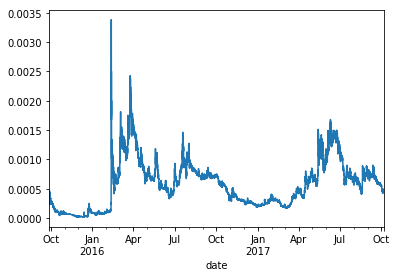

In [5]:
f = rs_full.close[240:].plot()

In [6]:
# 24-hour moving average of typical price
mva_tp_24 = rs_full['typical_price'].rolling(24).mean().bfill()
mva_tp_48 = rs_full['typical_price'].rolling(48).mean().bfill()

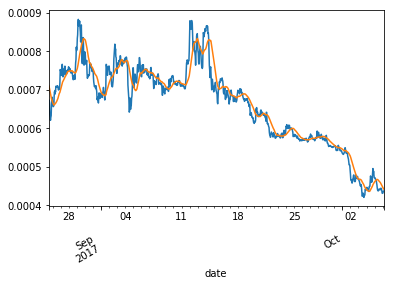

In [7]:
fig = plt.figure()
f = rs_full['typical_price'].iloc[-1000:].plot()
f = mva_tp_24.iloc[-1000:].plot()
fig.autofmt_xdate()

In [8]:
# calculate slopes/derivatives of 15-min mva
mva_tp_24_diff = mva_tp_24.diff().bfill()
mva_tp_24_diff2 = mva_tp_24_diff.diff().bfill()
mva_tp_48_diff = mva_tp_48.diff().bfill()
mva_tp_48_diff2 = mva_tp_48_diff.diff().bfill()

In [9]:
mva_tp_24.shape

(17999,)

In [10]:
rs_full.shape

(17999, 10)

In [11]:
mva_tp_24_diff.shape

(17999,)

In [12]:
# could also use dp.make_mva_features(rs_full)
rs_full['mva_tp_24'] = mva_tp_24
rs_full['mva_tp_24_diff'] = mva_tp_24_diff
rs_full['mva_tp_24_diff2'] = mva_tp_24_diff2
rs_full['mva_tp_48'] = mva_tp_48
rs_full['mva_tp_48_diff'] = mva_tp_48_diff
rs_full['mva_tp_48_diff2'] = mva_tp_48_diff2

In [23]:
# make mva features of direction_volume
rs_full['mva_dv_24'] = rs_full['direction_volume'].rolling(24).mean()
rs_full['mva_dv_24_diff'] = rs_full['direction_volume'].diff().bfill()

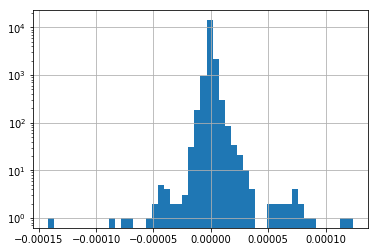

In [13]:
# whoa, some major outliers in the slopes...
f = mva_tp_24_diff.hist(bins=50)
plt.yscale('log')

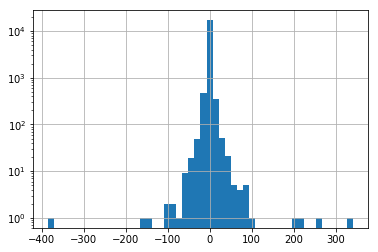

In [14]:
f = rs_full['direction_volume'].hist(bins=50)
plt.yscale('log')

# calculate the difference in price 24 hours from now, does it correlate to the current mva slope or direction_volume?

In [15]:
rs_full['24h_price_diff'] = rs_full['typical_price'].copy()

In [16]:
rs_full['24h_price_diff'] = np.hstack((np.repeat(rs_full['24h_price_diff'].iloc[24], 24), rs_full['typical_price'].iloc[24:].values - rs_full['typical_price'].iloc[:-24].values))

In [17]:
rs_full['24h_price_diff_pct'] = rs_full['24h_price_diff'] / rs_full['close']

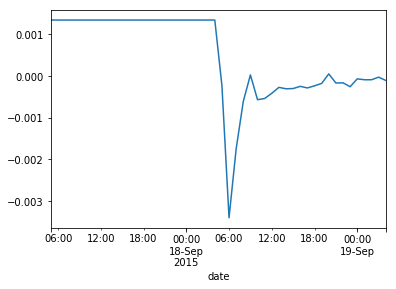

In [18]:
rs_full['24h_price_diff'].iloc[:48].plot()

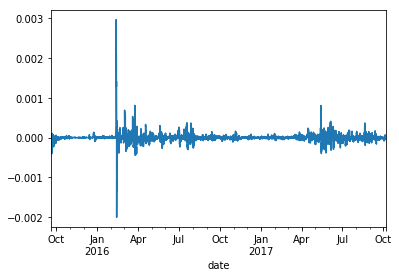

In [19]:
rs_full['24h_price_diff'].iloc[48:].plot()

In [25]:
rs_clip = rs_full.iloc[48:].copy()

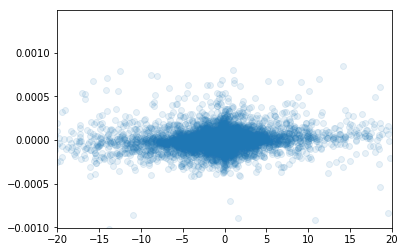

In [26]:
# weak correlation, but seems to be there
hist = 14  # number of points that the mva is behind the price diff
f = plt.scatter(rs_clip['direction_volume'].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.1)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*0.5, rs_clip['24h_price_diff'].max()*0.5])
xlim = plt.xlim([-20, 20])

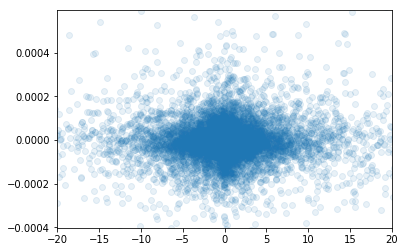

In [29]:
# weak correlation, but seems to be there
hist = 12  # number of points that the mva is behind the price diff
f = plt.scatter(rs_clip['mva_dv_24_diff'].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.1)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*0.2, rs_clip['24h_price_diff'].max()*0.2])
xlim = plt.xlim([-20, 20])

# bottom line: if the mva slope is positive, 12 hours later, the price will probably be up, proportional to the slope, and vice-versa

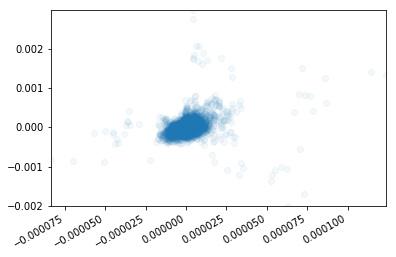

In [30]:
hist = 14  # number of points that the mva is behind the price diff
f = plt.scatter(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min(), rs_clip['24h_price_diff'].max()])
xlim = plt.xlim([rs_clip['mva_tp_24_diff'].min(), rs_clip['mva_tp_24_diff'].max()])
fig = plt.gcf()
fig.autofmt_xdate()

# the second derivative is not as informative

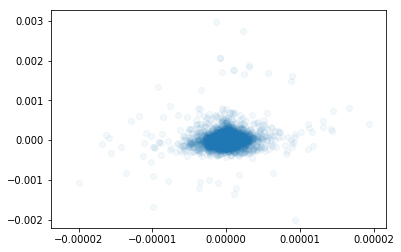

In [22]:
hist = 12  # number of points that the mva is behind the price diff
xcol = 'mva_tp_24_diff2'
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min()*0.5, rs_clip[xcol].max()*0.5])

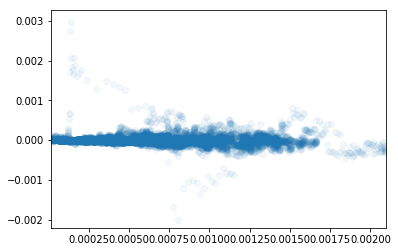

In [23]:
xcol = 'mva_tp_48'
hist = 12
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min(), rs_clip[xcol].max()])

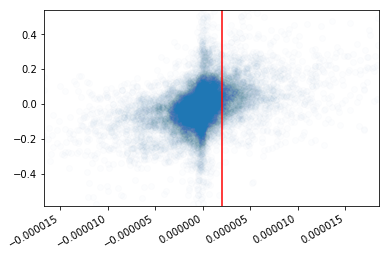

In [127]:
hist = 12
xcol = 'mva_tp_24_diff'
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff_pct'].iloc[24:].values, alpha=0.01)
ylim = plt.ylim([rs_clip['24h_price_diff_pct'].min()*0.3, rs_clip['24h_price_diff_pct'].max()*0.5])
xlim = plt.xlim([rs_clip[xcol].min()*0.2, rs_clip[xcol].max()*0.15])
fig = plt.gcf()
fig.autofmt_xdate()
plt.axvline(2e-6, c='r')

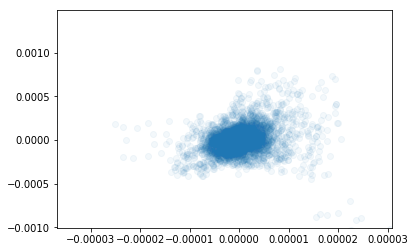

In [24]:
hist = 12
xcol = 'mva_tp_48_diff'
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*0.5, rs_clip['24h_price_diff'].max()*0.5])
xlim = plt.xlim([rs_clip[xcol].min()*0.5, rs_clip[xcol].max()*0.5])

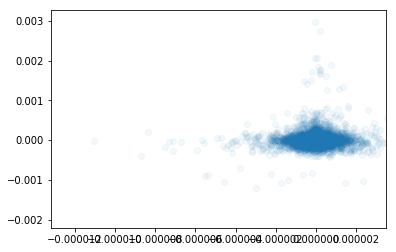

In [25]:
xcol = 'mva_tp_48_diff2'
f = plt.scatter(rs_clip[xcol].iloc[:-24].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min()*0.2, rs_clip[xcol].max()*0.1])

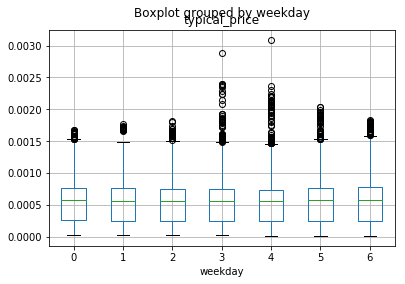

In [26]:
# Monday=0, Sunday=6
rs_clip.boxplot(column='typical_price', by='weekday')

(-0.0001, 0.0001)

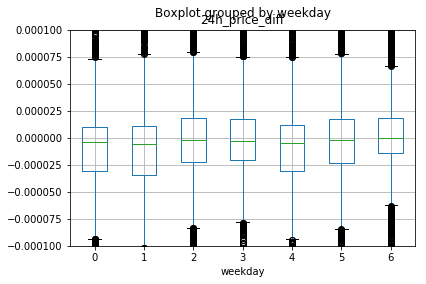

In [27]:
rs_clip.boxplot(column='24h_price_diff', by='weekday')
plt.ylim([-0.0001, 0.0001])

(-0.001, 0.001)

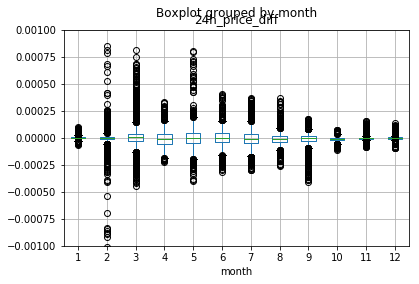

In [28]:
rs_clip.boxplot(column='24h_price_diff', by='month')
plt.ylim([-0.001, 0.001])

(-0.0001, 0.0001)

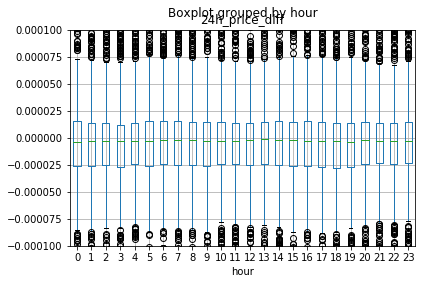

In [29]:
rs_clip.boxplot(column='24h_price_diff', by='hour')
plt.ylim([-0.0001, 0.0001])

# try fitting a linear model to the different historic times

In [31]:
hist = 24
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     575.0
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          5.62e-125
Time:                        16:19:46   Log-Likelihood:             1.3094e+05
No. Observations:               16897   AIC:                        -2.619e+05
Df Residuals:                   16895   BIC:                        -2.619e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.65e-07   8.02e-07     -0.829      0.407   -2.24e-06    9.07e-07
x1            -4.3410      0.181    -23.979      0.000      -4.696      -3.986
==============================================================================
Omnibus:                    22229.676   Durbin-Watson:                   0.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15328436.358
Skew:                           6.938   Prob(JB):                         0.00
Kurtosis:                     149.900   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
fit.rsquared

0.032912818141431655

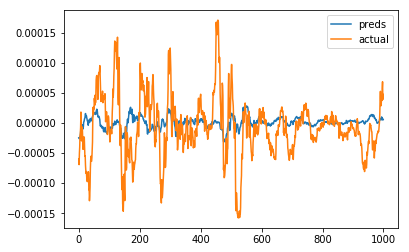

In [33]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [34]:
hist = 14
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1790.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:46   Log-Likelihood:             1.3151e+05
No. Observations:               16897   AIC:                        -2.630e+05
Df Residuals:                   16895   BIC:                        -2.630e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.98e-07   7.76e-07     -0.384      0.701   -1.82e-06    1.22e-06
x1             7.4147      0.175     42.312      0.000       7.071       7.758
==============================================================================
Omnibus:                    15419.484   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27027978.840
Skew:                           3.150   Prob(JB):                         0.00
Kurtosis:                     198.832   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

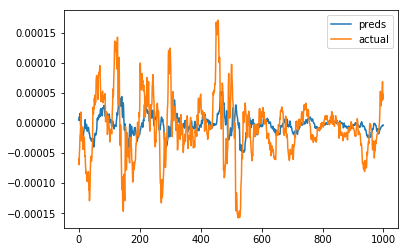

In [35]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [36]:
hist = 12
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     3193.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:46   Log-Likelihood:             1.3212e+05
No. Observations:               16897   AIC:                        -2.642e+05
Df Residuals:                   16895   BIC:                        -2.642e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.557e-07   7.48e-07     -0.342      0.732   -1.72e-06    1.21e-06
x1             9.5569      0.169     56.507      0.000       9.225       9.888
==============================================================================
Omnibus:                    14409.012   Durbin-Watson:                   0.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34041488.724
Skew:                           2.687   Prob(JB):                         0.00
Kurtosis:                     222.824   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

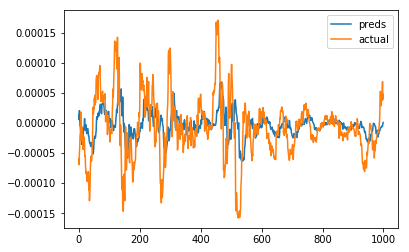

In [37]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [38]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff', 'mva_tp_48_diff']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     1614.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:46   Log-Likelihood:             1.3214e+05
No. Observations:               16897   AIC:                        -2.643e+05
Df Residuals:                   16894   BIC:                        -2.642e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.998e-07   7.48e-07     -0.401      0.688   -1.77e-06    1.17e-06
x1            10.3248      0.220     46.972      0.000       9.894      10.756
x2            -1.8721      0.343     -5.463      0.000      -2.544      -1.200
==============================================================================
Omnibus:                    14857.709   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33659162.390
Skew:                           2.868   Prob(JB):                         0.00
Kurtosis:                     221.576   Cond. No.                     5.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

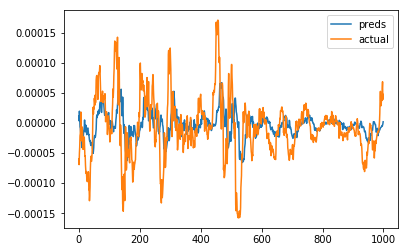

In [39]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [40]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday',
                             'month',
                             'hour']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     556.8
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:46   Log-Likelihood:             1.3219e+05
No. Observations:               16897   AIC:                        -2.644e+05
Df Residuals:                   16890   BIC:                        -2.643e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.581e-06   2.29e-06      1.564      0.118   -9.06e-07    8.07e-06
x1            10.1611      0.220     46.182      0.000       9.730      10.592
x2            -1.8846      0.342     -5.503      0.000      -2.556      -1.213
x3           8.69e-07      1e-07      8.686      0.000    6.73e-07    1.07e-06
x4           6.72e-07   3.73e-07      1.801      0.072   -5.93e-08     1.4e-06
x5         -8.656e-07   2.14e-07     -4.039      0.000   -1.29e-06   -4.46e-07
x6         -6.864e-09   1.08e-07     -0.064      0.949   -2.18e-07    2.04e-07
==============================================================================
Omnibus:                    15080.777   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34081609.572
Skew:                           2.956   Prob(JB):                         0.00
Kurtosis:                     222.940   Cond. No.                     7.54e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday',
                             'month']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     668.1
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:47   Log-Likelihood:             1.3219e+05
No. Observations:               16897   AIC:                        -2.644e+05
Df Residuals:                   16891   BIC:                        -2.643e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.502e-06   1.93e-06      1.819      0.069   -2.72e-07    7.28e-06
x1            10.1611      0.220     46.183      0.000       9.730      10.592
x2            -1.8846      0.342     -5.503      0.000      -2.556      -1.213
x3          8.689e-07      1e-07      8.686      0.000    6.73e-07    1.06e-06
x4          6.719e-07   3.73e-07      1.801      0.072   -5.93e-08     1.4e-06
x5         -8.656e-07   2.14e-07     -4.039      0.000   -1.29e-06   -4.46e-07
==============================================================================
Omnibus:                    15080.127   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34081275.315
Skew:                           2.955   Prob(JB):                         0.00
Kurtosis:                     222.939   Cond. No.                     4.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     830.4
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:47   Log-Likelihood:             1.3218e+05
No. Observations:               16897   AIC:                        -2.643e+05
Df Residuals:                   16892   BIC:                        -2.643e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.064e-06   1.35e-06     -1.534      0.125    -4.7e-06    5.73e-07
x1            10.1610      0.220     46.162      0.000       9.730      10.592
x2            -1.8106      0.342     -5.292      0.000      -2.481      -1.140
x3          8.653e-07      1e-07      8.647      0.000    6.69e-07    1.06e-06
x4          6.709e-07   3.73e-07      1.798      0.072   -6.07e-08     1.4e-06
==============================================================================
Omnibus:                    15218.844   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34159263.741
Skew:                           3.012   Prob(JB):                         0.00
Kurtosis:                     223.187   Cond. No.                     3.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     1106.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:19:47   Log-Likelihood:             1.3218e+05
No. Observations:               16897   AIC:                        -2.643e+05
Df Residuals:                   16893   BIC:                        -2.643e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.196e-08   7.46e-07     -0.070      0.945   -1.52e-06    1.41e-06
x1            10.1735      0.220     46.239      0.000       9.742      10.605
x2            -1.7966      0.342     -5.252      0.000      -2.467      -1.126
x3           8.68e-07      1e-07      8.674      0.000    6.72e-07    1.06e-06
==============================================================================
Omnibus:                    15212.921   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34136166.832
Skew:                           3.009   Prob(JB):                         0.00
Kurtosis:                     223.113   Cond. No.                     3.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

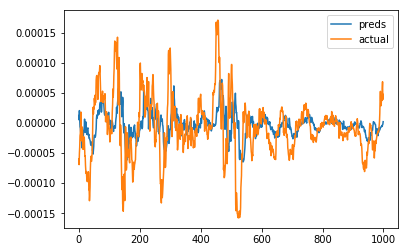

In [44]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [45]:
# make sure sklearn gives us the same thing
from sklearn.linear_model import LinearRegression as lr

In [46]:
reg = lr()
X = rs_clip[['mva_tp_24_diff',
             'mva_tp_48_diff',
             'direction_volume']].iloc[24 - hist:-hist][:-1000]
y = rs_clip['24h_price_diff'].iloc[24:][:-1000]
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
reg.score(X, y)

0.16415693888530514

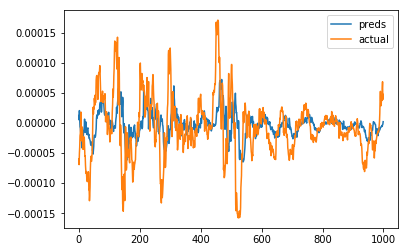

In [48]:
preds2 = reg.predict(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist][-1000:])
plt.plot(preds2, label='preds')
plt.plot(rs_clip['24h_price_diff'].iloc[24:][-1000:].values, label='actual')
l = plt.legend()

In [49]:
np.allclose(preds2, preds)

True

In [50]:
fit.conf_int()

array([[ -1.51503029e-06,   1.41111619e-06],
       [  9.74222496e+00,   1.06047526e+01],
       [ -2.46712617e+00,  -1.12611116e+00],
       [  6.71884567e-07,   1.06417533e-06]])

# does it work a little better on more recent data?

In [51]:
rs_clip.shape

(17921, 17)

In [65]:
cut = 10000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     733.1
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:22:03   Log-Likelihood:                 56952.
No. Observations:                6897   AIC:                        -1.139e+05
Df Residuals:                    6893   BIC:                        -1.139e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.24e-07   7.56e-07      1.222      0.222   -5.58e-07    2.41e-06
x1            13.0986      0.351     37.342      0.000      12.411      13.786
x2            -4.4040      0.505     -8.718      0.000      -5.394      -3.414
x3          8.893e-07   1.11e-07      8.006      0.000    6.72e-07    1.11e-06
==============================================================================
Omnibus:                     2150.687   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           137631.375
Skew:                           0.640   Prob(JB):                         0.00
Kurtosis:                      24.847   Cond. No.                     5.25e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

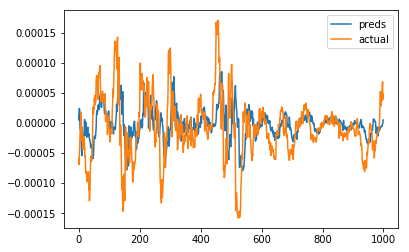

In [67]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [70]:
cut = 10000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     1050.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:22:13   Log-Likelihood:                 56914.
No. Observations:                6897   AIC:                        -1.138e+05
Df Residuals:                    6894   BIC:                        -1.138e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.365e-07    7.6e-07      1.101      0.271   -6.54e-07    2.33e-06
x1            11.0149      0.258     42.673      0.000      10.509      11.521
x2          8.876e-07   1.12e-07      7.948      0.000    6.69e-07    1.11e-06
==============================================================================
Omnibus:                     1948.898   Durbin-Watson:                   0.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133952.934
Skew:                           0.441   Prob(JB):                         0.00
Kurtosis:                      24.572   Cond. No.                     2.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

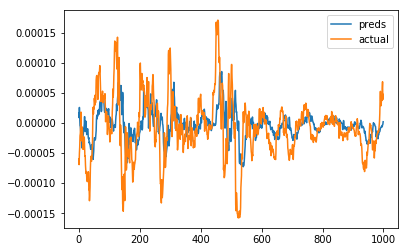

In [71]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

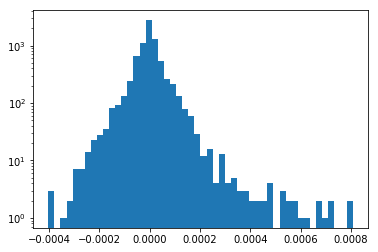

In [72]:
f = plt.hist(y, bins=50)
s = plt.yscale('log')

In [73]:
cut = 5000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     1893.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:22:15   Log-Likelihood:                 98618.
No. Observations:               11897   AIC:                        -1.972e+05
Df Residuals:                   11894   BIC:                        -1.972e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.178e-08   5.58e-07      0.075      0.940   -1.05e-06    1.14e-06
x1            11.3254      0.194     58.268      0.000      10.944      11.706
x2          8.694e-07   8.84e-08      9.840      0.000    6.96e-07    1.04e-06
==============================================================================
Omnibus:                     2917.133   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141681.213
Skew:                           0.339   Prob(JB):                         0.00
Kurtosis:                      19.893   Cond. No.                     2.23e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
def reject_outliers(sr, iq_range=0.5):
    # gets the iqr within the iq_range, and drops anything outside 1.5iqr of the 1st and 3rd quartiles
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    low_cut = qlow - 1.5 * iqr
    hi_cut = qhigh + 1.5 * iqr
    return sr[(sr < hi_cut) & (sr > low_cut)]

In [75]:
# get non-outliers in ydata for fit
non_out_price_diff = reject_outliers(rs_clip['24h_price_diff'])
idx = non_out_price_diff.index

In [76]:
non_out_price_diff.shape

(15165,)

In [77]:
rs_clip['24h_price_diff'].iloc[24:].shape

(17897,)

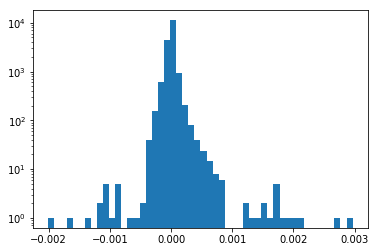

In [78]:
f = plt.hist(rs_clip['24h_price_diff'].iloc[24:], bins=50)
plt.yscale('log')

In [79]:
cut = 5000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].loc[idx].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].loc[idx].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     439.7
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          4.99e-183
Time:                        16:22:18   Log-Likelihood:                 82662.
No. Observations:                9141   AIC:                        -1.653e+05
Df Residuals:                    9138   BIC:                        -1.653e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.855e-06   3.03e-07     -9.409      0.000   -3.45e-06   -2.26e-06
x1             6.6140      0.241     27.449      0.000       6.142       7.086
x2           7.57e-07   8.71e-08      8.686      0.000    5.86e-07    9.28e-07
==============================================================================
Omnibus:                       82.796   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.008
Skew:                          -0.093   Prob(JB):                     3.21e-27
Kurtosis:                       3.535   Cond. No.                     2.79e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

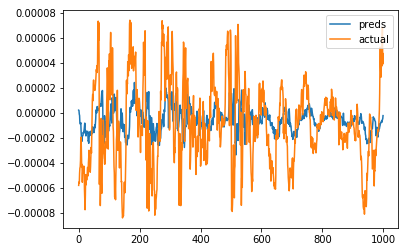

In [80]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

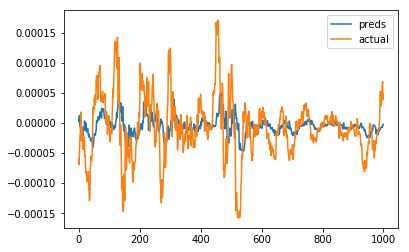

In [81]:
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]

preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

# it seems cutting off the first few thousand points helps. Beyond that, you don't get too much.  Seems like removing outliers is not a good thing here, really reduces the r-squared

In [82]:
cut = 5000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     1893.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):               0.00
Time:                        16:22:20   Log-Likelihood:                 98618.
No. Observations:               11897   AIC:                        -1.972e+05
Df Residuals:                   11894   BIC:                        -1.972e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.178e-08   5.58e-07      0.075      0.940   -1.05e-06    1.14e-06
x1            11.3254      0.194     58.268      0.000      10.944      11.706
x2          8.694e-07   8.84e-08      9.840      0.000    6.96e-07    1.04e-06
==============================================================================
Omnibus:                     2917.133   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141681.213
Skew:                           0.339   Prob(JB):                         0.00
Kurtosis:                      19.893   Cond. No.                     2.23e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
confs = fit.conf_int()

In [84]:
confs[:, 0]

array([ -1.05161886e-06,   1.09444096e+01,   6.96223673e-07])

In [85]:
confs[:, 1]

array([  1.13518621e-06,   1.17063870e+01,   1.04260657e-06])

In [86]:
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:].values[cut:])

In [87]:
X[-1]

array([  1.00000000e+00,   1.96875000e-06,  -2.41020520e-01])

In [96]:
last_price = rs_clip.iloc[-1]['close']

In [97]:
sum(X[-1] * confs[:, 0])

2.0327383336611281e-05

In [98]:
sum(X[-1] * confs[:, 1])

2.3930845996306764e-05

In [99]:
fit.predict(X)[-1]

2.2129114666459021e-05

In [100]:
sum(X[-1] * confs[:, 0]) / last_price

0.041399966062344765

In [101]:
sum(X[-1] * confs[:, 1]) / last_price

0.048738993882498499

In [102]:
fit.predict(X)[-1] / last_price

0.045069479972421632

In [103]:
confs = fit.conf_int(alpha=0.01)

In [104]:
confs

array([[ -1.39527522e-06,   1.47884257e-06],
       [  1.08246649e+01,   1.18261317e+01],
       [  6.41789609e-07,   1.09704064e-06]])

In [105]:
sum(X[-1] * confs[:, 0]) / last_price

0.040246638027580439

In [106]:
sum(X[-1] * confs[:, 1]) / last_price

0.049892321917262832

In [108]:
# target price in 12 hours
(1 + fit.predict(X)[-1] / last_price) * last_price

0.00051312911466645903

In [109]:
# target price in 6 hours
(1 + (fit.predict(X)[-1] / last_price) / 2) * last_price

0.00050206455733322946

In [110]:
# target price in 3 hours
(1 + (fit.predict(X)[-1] / last_price) / 4) * last_price

0.00049653227866661479

# load all the data, and see if it seems to follow the trend in general